Income Type Performance Test (Default Rate)
H₀: Default rate is independent of income type.
H₁: Default rate depends on income type.
Chi-square: Statistic=1253.47, p=0.0000, df=7
Conclusion: Reject H₀; default rate depends on income type.

Default Proportions by Income Type:
TARGET                       0         1
NAME_INCOME_TYPE                        
Businessman           1.000000  0.000000
Commercial associate  0.925157  0.074843
Maternity leave       0.600000  0.400000
Pensioner             0.946136  0.053864
State servant         0.942450  0.057550
Student               1.000000  0.000000
Unemployed            0.636364  0.363636
Working               0.904115  0.095885


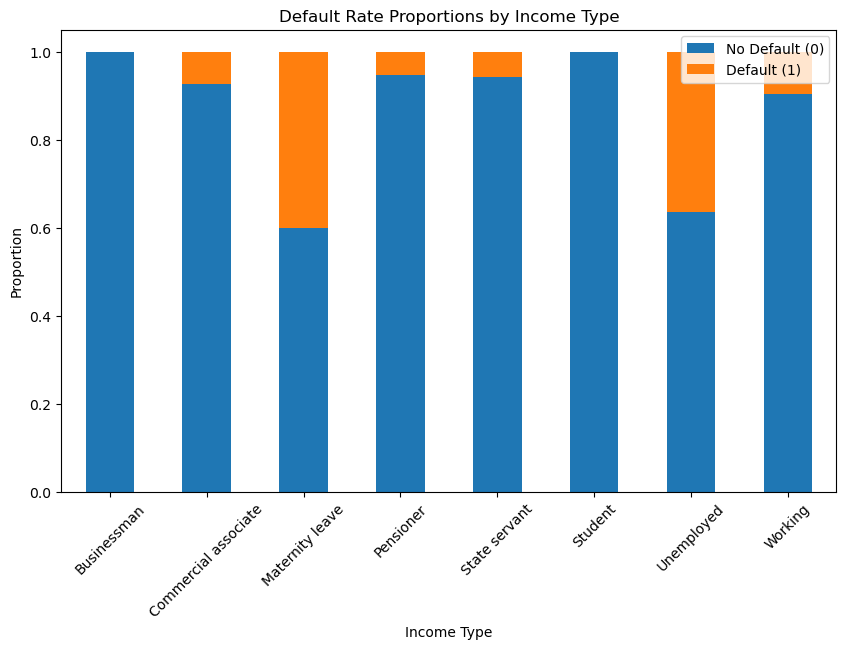

In [15]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
df = pd.read_csv('application_train.csv')
df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].fillna('Unknown')

# Create contingency table
contingency_table = pd.crosstab(df['NAME_INCOME_TYPE'], df['TARGET'])

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
alpha = 0.05
print("Income Type Performance Test (Default Rate)")
print("H₀: Default rate is independent of income type.")
print("H₁: Default rate depends on income type.")
print(f"Chi-square: Statistic={chi2:.2f}, p={p:.4f}, df={dof}")
print("Conclusion:", "Reject H₀; default rate depends on income type." if p < alpha else "Fail to reject H₀.")

# Proportion analysis
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
print("\nDefault Proportions by Income Type:")
print(proportions)

# Visualization
proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Default Rate Proportions by Income Type')
plt.xlabel('Income Type')
plt.ylabel('Proportion')
plt.legend(['No Default (0)', 'Default (1)'])
plt.xticks(rotation=45)
plt.show()

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime

# Load and clean data
df = pd.read_csv('application_train.csv')
df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].fillna('Unknown')
df['TARGET'] = pd.to_numeric(df['TARGET'], errors='coerce')

# === Assumption Checks ===
print("\n=== Logistic Regression Assumption Checks ===")
assumptions_met = True

# 1. Binary Outcome Check
unique_target = df['TARGET'].dropna().unique()
if set(unique_target).issubset({0, 1}):
    print("✅ TARGET is binary.")
else:
    print("❌ TARGET is not binary.")
    assumptions_met = False

# 2. Missing Values Check
missing_X = df['NAME_INCOME_TYPE'].isnull().sum()
missing_y = df['TARGET'].isnull().sum()
if missing_X == 0 and missing_y == 0:
    print("✅ No missing values in NAME_INCOME_TYPE or TARGET.")
else:
    print(f"⚠️ Missing values — NAME_INCOME_TYPE: {missing_X}, TARGET: {missing_y}")
    assumptions_met = False

# 3. One-hot encode NAME_INCOME_TYPE (drop first as baseline)
X_raw = pd.get_dummies(df['NAME_INCOME_TYPE'], prefix='INCOME', drop_first=True)
X_raw = sm.add_constant(X_raw)
X_clean = X_raw.apply(pd.to_numeric, errors='coerce')
y_clean = pd.to_numeric(df['TARGET'], errors='coerce')

# 4. Align and drop NaNs
valid_index = X_clean.dropna().index.intersection(y_clean.dropna().index)
X_final = X_clean.loc[valid_index].astype(float)
y_final = y_clean.loc[valid_index].astype(float)

# 5. Multicollinearity Check (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_final.columns
vif_data["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)

if vif_data["VIF"].max() < 5:
    print("✅ No severe multicollinearity detected.")
else:
    print("⚠️ High VIF values detected. Consider dropping or combining correlated features.")
    assumptions_met = False

# 6. Sample Size Check
min_class_count = y_final.value_counts().min()
num_predictors = X_final.shape[1] - 1  # exclude constant
if min_class_count >= 10 * num_predictors:
    print(f"✅ Sample size is sufficient: {min_class_count} cases in minority class for {num_predictors} predictors.")
else:
    print(f"❌ Sample size may be insufficient: {min_class_count} cases for {num_predictors} predictors.")
    assumptions_met = False

# 7. Linearity of Log-Odds (Placeholder)
print("ℹ️ Linearity of log-odds not tested here. Recommended for continuous predictors using Box-Tidwell.")

# Final decision
if assumptions_met:
    print("\n✅ All key assumptions are met. Proceeding with logistic regression...\n")
else:
    print("\n❌ One or more assumptions not met. Review before proceeding with logistic regression.\n")

# === Fit Logistic Regression ===
model = sm.Logit(y_final, X_final).fit_regularized(method='l1', alpha=0.1)

# === Logistic Regression Summary ===
print("\n=== Logistic Regression for Loan Default Risk ===")
print(model.summary())

# === Business-Friendly Interpretations ===
print("\n=== Business-Friendly Interpretations ===")

# Correctly detect baseline category
all_categories = sorted(df['NAME_INCOME_TYPE'].dropna().unique())
dummy_categories = [col.replace('INCOME_', '') for col in X_final.columns if col.startswith('INCOME_')]
baseline_income = list(set(all_categories) - set(dummy_categories))[0]

# Baseline odds
intercept = model.params['const']
baseline_odds = np.exp(intercept)
print(f"Baseline ({baseline_income}): log-odds = {intercept:.4f}, odds of default = {baseline_odds:.4f}")

# Model equation
equation_terms = [f"{model.params[col]:+.4f}·{col}" for col in X_final.columns[1:]]
equation = f"log(p / (1 - p)) = {intercept:.4f} " + " ".join(equation_terms)
print(f"\nModel Equation:\n{equation}")

# Interpret each income type relative to baseline
for col in X_final.columns[1:]:
    coef = model.params[col]
    odds_ratio = np.exp(coef)
    direction = "increases" if coef > 0 else "reduces"
    magnitude = (odds_ratio - 1) * 100 if coef > 0 else (1 - odds_ratio) * 100
    income_type = col.replace('INCOME_', '')

    print(f"\n{income_type} vs baseline ({baseline_income}):")
    print(f"- Coefficient: {coef:.4f}")
    print(f"- Odds Ratio: {odds_ratio:.3f}")
    print(f"- Interpretation: {income_type} {direction} odds of default by {abs(magnitude):.1f}% compared to {baseline_income}.")
    print(f"- Strategy: {'Apply caution' if coef > 0 else 'Prioritize'} {income_type} applicants in approval and pricing.")



=== Logistic Regression Assumption Checks ===
✅ TARGET is binary.
✅ No missing values in NAME_INCOME_TYPE or TARGET.

Variance Inflation Factor (VIF):
                       Feature           VIF
0                        const  30751.100000
1  INCOME_Commercial associate   5494.561020
2       INCOME_Maternity leave      1.499976
3             INCOME_Pensioner   4540.323575
4         INCOME_State servant   2018.057599
5               INCOME_Student      2.799836
6            INCOME_Unemployed      3.199771
7               INCOME_Working   7680.068618
⚠️ High VIF values detected. Consider dropping or combining correlated features.
✅ Sample size is sufficient: 24825 cases in minority class for 7 predictors.
ℹ️ Linearity of log-odds not tested here. Recommended for continuous predictors using Box-Tidwell.

❌ One or more assumptions not met. Review before proceeding with logistic regression.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.278445

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 5 out of 8 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               307511
Model:                          Logit   Df Residuals:                   307503
Method:                           MLE   Df Model:                            7
Date:                Fri, 05 Sep 2025   Pseudo R-squ.:                0.007500
Time:                        18:46:23   Log-Likelihood:                -85624.
converged:                       True   LL-Null:                       -86271.
Covariance Type:            nonrobust   LLR p-value:                3.192e-275
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -2.3830      1.137     -2.096      0.036      -4.612      -0.154
INCOME_Commercial associate    -0.1316      1.137     -0.116      0.908      -2.

In [17]:
# ============================================
# 1. Default Proportions Dataset
# ============================================
default_props_df = (
    contingency_table
    .div(contingency_table.sum(axis=1), axis=0)[1]  # column '1' = default
    .reset_index()
    .rename(columns={1: 'Default %'})
)
default_props_df['Default %'] = (default_props_df['Default %'] * 100).round(2)

print("\n=== Default Proportions Dataset ===")
print(default_props_df)

# ============================================
# 2. Logistic Regression Summary Dataset
# ============================================

# Detect actual baseline from dummy encoding
all_categories = sorted(df['NAME_INCOME_TYPE'].dropna().unique())
dummy_categories = [col.replace('INCOME_', '') for col in X_final.columns if col.startswith('INCOME_')]
baseline_income_type = list(set(all_categories) - set(dummy_categories))[0]

intercept = model.params['const']
baseline_odds = np.exp(intercept)

logit_summary_rows = [{
    'Income Type': baseline_income_type,
    'Coefficient': None,
    'Odds Ratio': None,
    'Change vs Baseline': 'Baseline',
    'Baseline Odds of Default': round(baseline_odds, 4)
}]

# Other categories
for col in X_final.columns[1:]:
    income_type = col.replace('INCOME_', '')
    coef = model.params[col]
    odds_ratio = np.exp(coef)
    pct_change = (odds_ratio - 1) * 100
    logit_summary_rows.append({
        'Income Type': income_type,
        'Coefficient': round(coef, 4),
        'Odds Ratio': round(odds_ratio, 3),
        'Change vs Baseline': f"{pct_change:.1f}%",
        'Baseline Odds of Default': None
    })

logit_summary_df = pd.DataFrame(logit_summary_rows)

print("\n=== Logistic Regression Summary Dataset ===")
print(logit_summary_df)

# ============================================
# Optional: Export for Power BI
# ============================================
# Change the paths below if needed to avoid PermissionError
# Example: export to a 'results' folder in your working directory
# import os
# os.makedirs("results", exist_ok=True)
default_props_df.to_csv("results/default_proportions_income_type_performance.csv", index=False)
logit_summary_df.to_csv("results/logistic_regression_summary_income_type_performance.csv", index=False)



=== Default Proportions Dataset ===
       NAME_INCOME_TYPE  Default %
0           Businessman       0.00
1  Commercial associate       7.48
2       Maternity leave      40.00
3             Pensioner       5.39
4         State servant       5.75
5               Student       0.00
6            Unemployed      36.36
7               Working       9.59

=== Logistic Regression Summary Dataset ===
            Income Type  Coefficient  Odds Ratio Change vs Baseline  \
0           Businessman          NaN         NaN           Baseline   
1  Commercial associate      -0.1316       0.877             -12.3%   
2       Maternity leave       0.4791       1.615              61.5%   
3             Pensioner      -0.4829       0.617             -38.3%   
4         State servant      -0.4129       0.662             -33.8%   
5               Student      -0.5609       0.571             -42.9%   
6            Unemployed       1.8736       6.511             551.1%   
7               Working       0.139

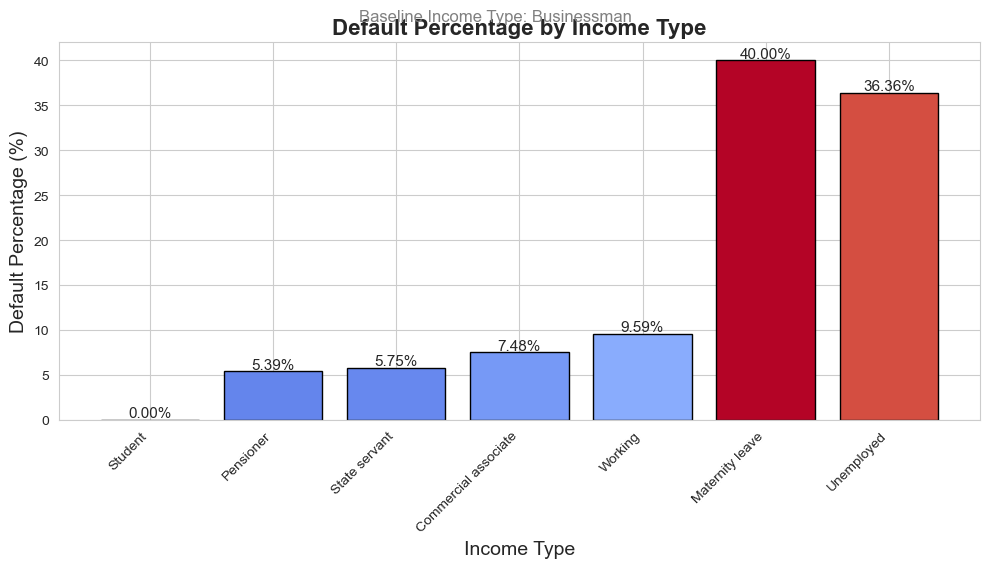

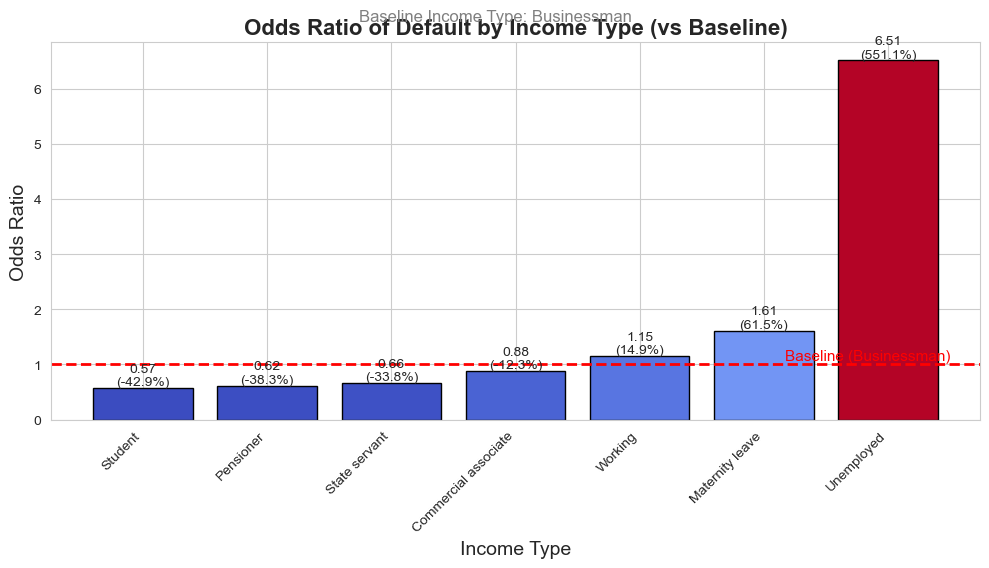

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib import cm
from matplotlib.colors import Normalize

# Ensure output folder exists
os.makedirs("results", exist_ok=True)

# Identify baseline
baseline_income_type = logit_summary_df.loc[0, 'Income Type']

# ==============================
# 1. Create common order by Odds Ratio
# ==============================
# Drop NaN for odds ratio and sort ascending (low risk → high risk)
odds_sorted = (
    logit_summary_df
    .dropna(subset=['Odds Ratio'])
    .sort_values('Odds Ratio', ascending=True)
)
income_order = odds_sorted['Income Type'].tolist()

# Reorder default_props_df to match
default_props_ordered = default_props_df.set_index('NAME_INCOME_TYPE').loc[income_order].reset_index()
odds_ratio_ordered = odds_sorted.copy()

# ==============================
# 2. Default Percentage Chart (Coolwarm)
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_def = Normalize(vmin=default_props_ordered['Default %'].min(),
                     vmax=default_props_ordered['Default %'].max())
colors_def = cm.coolwarm(norm_def(default_props_ordered['Default %']))

bars = plt.bar(default_props_ordered['NAME_INCOME_TYPE'],
               default_props_ordered['Default %'],
               color=colors_def, edgecolor='black')

# Highlight baseline
for bar, label in zip(bars, default_props_ordered['NAME_INCOME_TYPE']):
    if label == baseline_income_type:
        bar.set_linewidth(2.5)
        bar.set_edgecolor('black')
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 "Baseline", ha='center', fontsize=10, fontweight='bold', color='black')

plt.title("Default Percentage by Income Type", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Income Type: {baseline_income_type}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Income Type", fontsize=14)
plt.ylabel("Default Percentage (%)", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3,
             f"{height:.2f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.savefig("results/default_percentage_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()

# ==============================
# 3. Odds Ratio Chart (Coolwarm)
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_or = Normalize(vmin=odds_ratio_ordered['Odds Ratio'].min(),
                    vmax=odds_ratio_ordered['Odds Ratio'].max())
colors_or = cm.coolwarm(norm_or(odds_ratio_ordered['Odds Ratio']))

bars = plt.bar(odds_ratio_ordered['Income Type'],
               odds_ratio_ordered['Odds Ratio'],
               color=colors_or, edgecolor='black')

# Baseline line + label
plt.axhline(1, color='red', linestyle='--', linewidth=2)
plt.text(len(odds_ratio_ordered)-0.5, 1.02,
         f"Baseline ({baseline_income_type})",
         color='red', fontsize=11, va='bottom', ha='right')

plt.title("Odds Ratio of Default by Income Type (vs Baseline)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Income Type: {baseline_income_type}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Income Type", fontsize=14)
plt.ylabel("Odds Ratio", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate bars
for bar, change in zip(bars, odds_ratio_ordered['Change vs Baseline']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05,
             f"{height:.2f}\n({change})", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("results/odds_ratio_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()



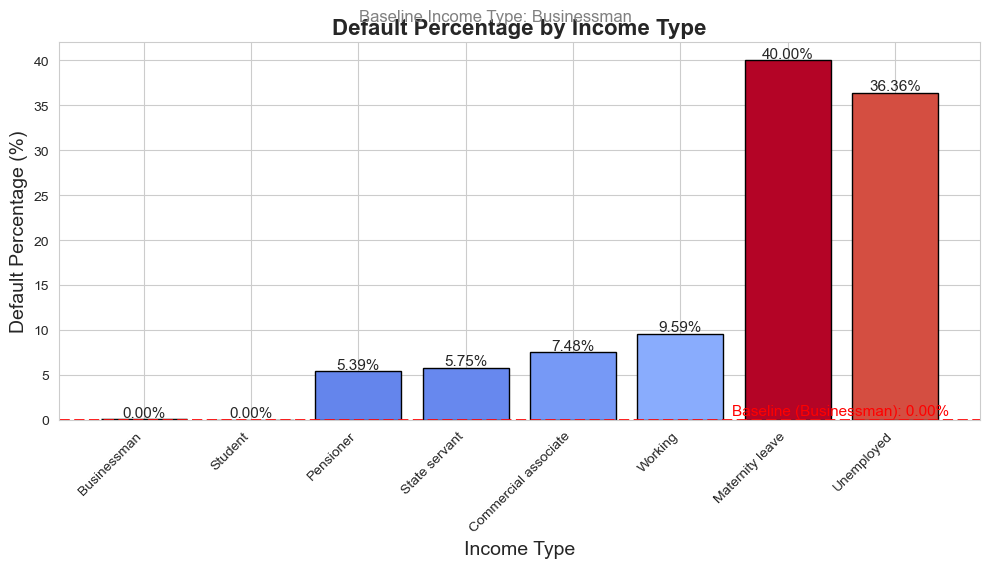

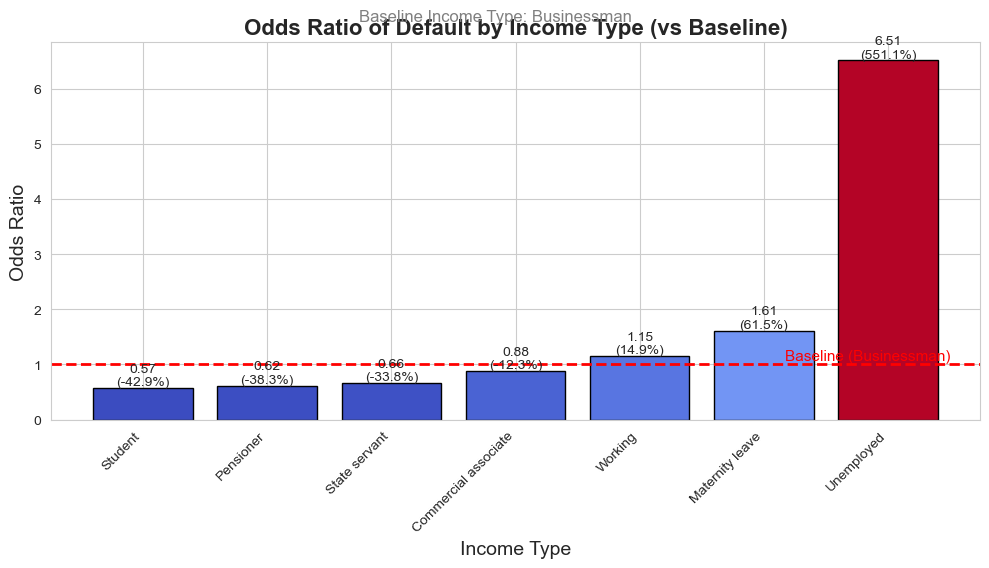

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib import cm
from matplotlib.colors import Normalize

# Ensure output folder exists
os.makedirs("results", exist_ok=True)

# Identify baseline
baseline_income_type = logit_summary_df.loc[0, 'Income Type']

# ==============================
# 1. Create common order by Odds Ratio (low → high risk)
# ==============================
odds_sorted = (
    logit_summary_df
    .dropna(subset=['Odds Ratio'])
    .sort_values('Odds Ratio', ascending=True)
)
income_order = odds_sorted['Income Type'].tolist()

# Ensure baseline is in the order list
if baseline_income_type not in income_order:
    income_order = [baseline_income_type] + income_order

# Reorder default_props_df to match
default_props_ordered = default_props_df.set_index('NAME_INCOME_TYPE').loc[income_order].reset_index()
odds_ratio_ordered = odds_sorted.copy()

# ==============================
# 2. Default Percentage Chart (Coolwarm + baseline dashed line)
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_def = Normalize(vmin=default_props_ordered['Default %'].min(),
                     vmax=default_props_ordered['Default %'].max())
colors_def = cm.coolwarm(norm_def(default_props_ordered['Default %']))

bars = plt.bar(default_props_ordered['NAME_INCOME_TYPE'],
               default_props_ordered['Default %'],
               color=colors_def, edgecolor='black')

# Safely get baseline default percentage
mask = default_props_ordered['NAME_INCOME_TYPE'] == baseline_income_type
if mask.any():
    baseline_value = default_props_ordered.loc[mask, 'Default %'].iloc[0]
    # Draw baseline dashed line + label
    plt.axhline(baseline_value, color='red', linestyle='--', linewidth=2)
    plt.text(len(default_props_ordered)-0.5, baseline_value + 0.2,
             f"Baseline ({baseline_income_type}): {baseline_value:.2f}%",
             color='red', fontsize=11, va='bottom', ha='right')

# Highlight baseline bar
for bar, label in zip(bars, default_props_ordered['NAME_INCOME_TYPE']):
    if label == baseline_income_type:
        bar.set_linewidth(2.5)
        bar.set_edgecolor('black')

# Titles & labels
plt.title("Default Percentage by Income Type", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Income Type: {baseline_income_type}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Income Type", fontsize=14)
plt.ylabel("Default Percentage (%)", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate bars
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.3,
             f"{h:.2f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.savefig("results/default_percentage_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()

# ==============================
# 3. Odds Ratio Chart (Coolwarm + baseline dashed line at 1.0)
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_or = Normalize(vmin=odds_ratio_ordered['Odds Ratio'].min(),
                    vmax=odds_ratio_ordered['Odds Ratio'].max())
colors_or = cm.coolwarm(norm_or(odds_ratio_ordered['Odds Ratio']))

bars = plt.bar(odds_ratio_ordered['Income Type'],
               odds_ratio_ordered['Odds Ratio'],
               color=colors_or, edgecolor='black')

# Baseline line + label
plt.axhline(1, color='red', linestyle='--', linewidth=2)
plt.text(len(odds_ratio_ordered)-0.5, 1.02,
         f"Baseline ({baseline_income_type})",
         color='red', fontsize=11, va='bottom', ha='right')

plt.title("Odds Ratio of Default by Income Type (vs Baseline)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Income Type: {baseline_income_type}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Income Type", fontsize=14)
plt.ylabel("Odds Ratio", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate bars
for bar, change in zip(bars, odds_ratio_ordered['Change vs Baseline']):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.05,
             f"{h:.2f}\n({change})", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("results/odds_ratio_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()
